# Time Series Analysis For El-Paso

## Getting Started














In this project, I will perform Time Series Analysis using Zillow's historical median house prices for El-Paso Texas. The aim of the project is to provide the best zip codes to invest in for a regional real estate developer.



## Predicting the top 5 zip codes in El Paso, Texas to invest in

In [1]:
#Importing Libraries
#for math and data structure
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
#for modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose as sd
import itertools
#for visualizations
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
zillow_data = pd.read_csv("zillow_data.csv")
zillow_data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


The data contains both descriptive and ordinal variables. the data contains median house prices for time period between April 1996 to April 2018.

# Data Preprocessing

In [3]:
df = zillow_data.groupby('State').get_group('TX')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


# Reshape from Wide to Long Format

In [4]:
def melt_data(df): 
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='Month', value_name='MeanValue')
    
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [5]:
df = melt_data(zillow_data)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [6]:
def make_datetimeindex(df,col_to_make_index = 'Month',drop=False,verbose=True):

    df[col_to_make_index] = pd.to_datetime(df[col_to_make_index],errors='coerce')
    df = df.set_index('Month',drop=drop)
    
    if verbose:
        display(df.index)
    return df

In [7]:
#putting time series to the dataset
df = make_datetimeindex(df)

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=3744704, freq=None)

In [8]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
Month,,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [9]:
df = df.rename({'Month':'MonthOrig'},axis=1)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MonthOrig,MeanValue
Month,,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [10]:
df_city =  df.groupby('City').get_group('El Paso')
df_county = df.groupby('CountyName').get_group('El Paso')

display(df_city.head(),df_city.index,df_county.head())

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MonthOrig,MeanValue
Month,,,,,,,,,
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
1996-04-01,93123,79912,El Paso,TX,El Paso,El Paso,26,1996-04-01,119700.0
1996-04-01,93146,79938,El Paso,TX,El Paso,El Paso,179,1996-04-01,98400.0
1996-04-01,93133,79924,El Paso,TX,El Paso,El Paso,491,1996-04-01,61700.0
1996-04-01,93119,79907,El Paso,TX,El Paso,El Paso,1136,1996-04-01,58900.0


DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=4828, freq=None)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MonthOrig,MeanValue
Month,,,,,,,,,
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
1996-04-01,93123,79912,El Paso,TX,El Paso,El Paso,26,1996-04-01,119700.0
1996-04-01,93146,79938,El Paso,TX,El Paso,El Paso,179,1996-04-01,98400.0
1996-04-01,93133,79924,El Paso,TX,El Paso,El Paso,491,1996-04-01,61700.0
1996-04-01,93596,80918,Colorado Springs,CO,Colorado Springs,El Paso,791,1996-04-01,128200.0


In [11]:
# checking number of zipcode in El paso
print(f"[i] There are {df_city['RegionName'].nunique()} zipcodes in El Paso")
display(df_city.head())
df_city.index

[i] There are 19 zipcodes in El Paso


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MonthOrig,MeanValue
Month,,,,,,,,,
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
1996-04-01,93123,79912,El Paso,TX,El Paso,El Paso,26,1996-04-01,119700.0
1996-04-01,93146,79938,El Paso,TX,El Paso,El Paso,179,1996-04-01,98400.0
1996-04-01,93133,79924,El Paso,TX,El Paso,El Paso,491,1996-04-01,61700.0
1996-04-01,93119,79907,El Paso,TX,El Paso,El Paso,1136,1996-04-01,58900.0


DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=4828, freq=None)

Make El Paso ( dict of Zipcodes dfs)

# EDA and Visualization

In [12]:
El_P = {}
for zipcode in df_city['RegionName'].unique():
    temp = df_city.groupby("RegionName").get_group(zipcode)
    El_P[zipcode]=temp.resample('MS').asfreq()
El_P

{79936:             RegionID  RegionName     City State    Metro CountyName  SizeRank  \
 Month                                                                           
 1996-04-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 1996-05-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 1996-06-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 1996-07-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 1996-08-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 ...              ...         ...      ...   ...      ...        ...       ...   
 2017-12-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 2018-01-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 2018-02-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 2018-03-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 2018-04-

[79936, 79912, 79938, 79924, 79907, 79925, 79915, 79904, 79902, 79934, 79930, 79932, 79905, 79903, 79935, 79901, 79922, 79911, 79836]


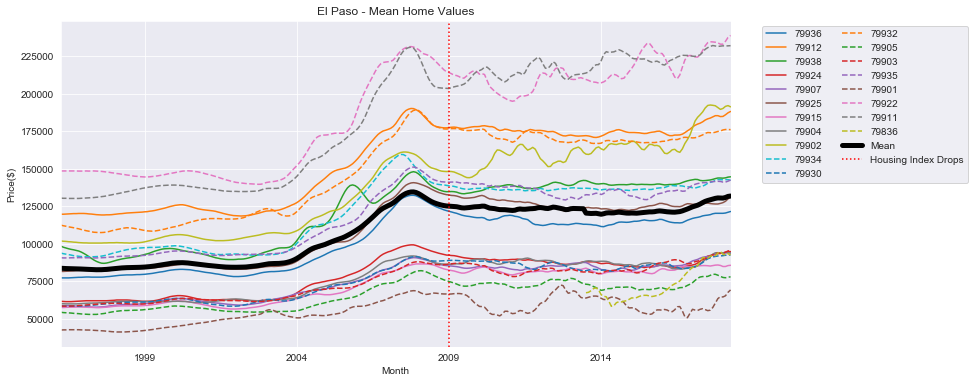

In [13]:
#Visualing all the zipcodes
def plot_ts_dict(df_dict,col='MeanValue',zipcodes=[]):
    
    if len(zipcodes)==0:
        zipcodes=list(df_dict.keys())
        
    print(zipcodes)
    
    cutoff = len(zipcodes)//2
    
        
    fig,ax = plt.subplots(figsize=(12,6))
    
    ts_dict = {}
    for i,zc in enumerate(zipcodes):
        if i <cutoff:
            ls='-'
        else:
            ls='--'
            
        ts = df_dict[zc][col].rename(zc)#.loc[zc]
        ts.plot(label=str(zc),ax=ax,ls=ls)
        ts_dict[zc] = ts

    ## CALCULTE MEAN   
    mean = pd.DataFrame(ts_dict).mean(axis=1)
    mean.plot(label='Mean',lw=5,color='black')

    crash = '01-2009'
    ax.axvline(crash, label='Housing Index Drops',color='red',ls=':')

    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
    ax.set(title='El Paso - Mean Home Values',
          ylabel='Price($)')

    return fig,ax,ts_dict
fig,ax,tsdict = plot_ts_dict(El_P)

In [14]:
# Importing stats libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from  statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot,lag_plot

In [15]:
# plotting acf and pacf
def plot_acf_pacf(ts, figsize=(10,8),lags=12):
    fig,ax = plt.subplots(nrows=3,figsize=figsize)
    ts.plot(ax=ax[0])
    plot_acf(ts,ax=ax[1],lags=lags)
    plot_pacf(ts, ax=ax[2],lags=lags) 
    plt.tight_layout()
    
    plt.suptitle(f"Zipcode: {ts.name}",y=1.1,fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    

In [16]:
zips = list(tsdict.keys())
zips

[79936,
 79912,
 79938,
 79924,
 79907,
 79925,
 79915,
 79904,
 79902,
 79934,
 79930,
 79932,
 79905,
 79903,
 79935,
 79901,
 79922,
 79911,
 79836]

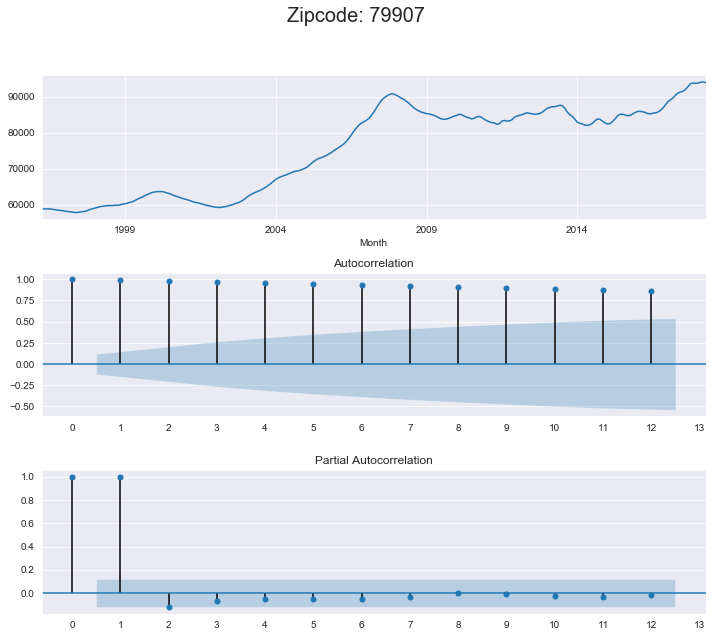

In [17]:
# viewing autocorr and partial corr
import matplotlib as mpl
ts = tsdict[79907]
ts = ts.rename(79907)
plot_acf_pacf(ts)

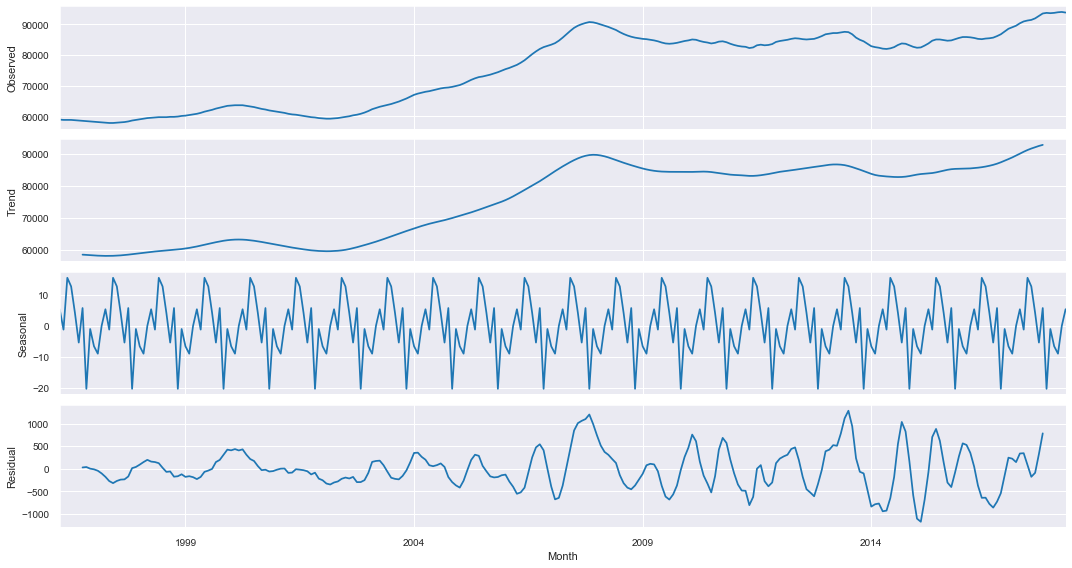

In [18]:
# Decomposing 
plt.style.use('seaborn-notebook')
mpl.rcParams['figure.figsize']=(15,8)

decomp = seasonal_decompose(ts)
decomp.plot();
plt.tight_layout()


# Modeling

In [19]:
def make_pdq_pdqm(ps=[0,1,3],ds=[0,1,2,3], 
                  qs=[0,1,3],make_seasonal=True,
                  m_values=[12]):
    import itertools
#    ps =range(p_range[0],p_range[1])
#    ds =range(d_range[0],d_range[1])
#    qs =range(q_range[0],q_range[1])
    
    params = {}
    params['pdq'] = list(itertools.product(ps,ds,qs))
    
    if make_seasonal:
        params['PDQm'] = list(itertools.product(ps,ds,qs,m_values))
    return params

# fs.ihelp(ji.get_train_test_split_index,0)
def get_train_test_split_index(ts, TEST_SIZE=0.1,min_test_ts=2):
    import math
    idx_split = math.floor(len(ts.index)*(1-TEST_SIZE))
    
    num_test_ts=len(ts.iloc[idx_split:])
    if num_test_ts<min_test_ts:
        print(f'[!] Warning: using TEST_SIZE={TEST_SIZE} produced {num_test_ts} test timestamps.')
        print("- Overriding TEST_SIZE and using min_test_ts instead.")
        idx_split = len(ts)-min_test_ts
    
    return idx_split


def train_test_split_ts(ts,test_size=0.2,min_test_ts=2):
    idx_split = get_train_test_split_index(ts,TEST_SIZE=test_size,
                                           min_test_ts=min_test_ts)
    ts_train = ts.iloc[:idx_split]
    ts_test = ts.iloc[idx_split:]
    return ts_train, ts_test

def get_now(return_dt = True, return_str=True, show=False):
    import datetime as dt
    import tzlocal as tz
    now=dt.datetime.now(tz=tz.get_localzone())
    str_time =now.strftime('%m/%d/%Y - %I:%M:%S %p')
    if show:
        print(str_time)
    
    output=[]
    if return_dt:
        output.append(now)
        
    if return_str:
        output.append(str_time)
    return output[:]


In [20]:
#setting up the parameters
params = make_pdq_pdqm()
print(params.keys())
print(params['pdq'][:10])
params['PDQm'][:10]

dict_keys(['pdq', 'PDQm'])
[(0, 0, 0), (0, 0, 1), (0, 0, 3), (0, 1, 0), (0, 1, 1), (0, 1, 3), (0, 2, 0), (0, 2, 1), (0, 2, 3), (0, 3, 0)]


[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 3, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 3, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 3, 12),
 (0, 3, 0, 12)]

New Grid Search Functions

In [22]:
# Grid search
from statsmodels.tsa.statespace.sarimax import SARIMAX
def grid_search (ts_train,pdq=None,pdqm=None,order_dict=None,
                                 make_seasonal=False, verbose=False, model_kws={}):

    from tqdm import trange
    
    if (pdq is None) & (order_dict is not None):
        pdq= order_dict['pdq']
    if (pdqm is None) & (order_dict is not None):
        pdqm= order_dict['PDQm']

    import tqdm
    from tqdm import trange

    start,start_str = get_now(return_dt=True, return_str=True)
    print(f'[i] STARTING GRID SEARCH @ {start_str}:')
    
    
    res = [['pdq','PDQM','AIC']]
    for i in trange((len(pdq))):
        comb = pdq[i]
        
     
        ## BRANCH POINT
        if make_seasonal:
            for combs in pdqm:
                try: 
                    model = SARIMAX(ts_train, order=comb, 
                                   seasonal_order =combs,enforce_stationarity=False,
                                   enforce_invertibility=False,**model_kws)

                    output= model.fit()
                    res.append([comb,combs,output.aic])
                except:
                    if verbose:
                        print(f"[!] Error running ({comb})({combs})")
                    continue
                    
                    
        if make_seasonal == False:
            try: 
                model = SARIMAX(ts_train, order=comb, 
                                enforce_stationarity=False, 
                                enforce_invertibility=False,**model_kws)

                output= model.fit()
                res.append([comb,'N/A',output.aic])
            except:
                if verbose:
                    print(f"[!] Error running ({comb})({combs})")
                    continue
                    
    end,end_str = get_now(return_dt=True, return_str=True)
    elapsed = end-start
    print(f"[i] GRID SEARCH FINISHED AT {end_str}")
    print(f"\tTotal Time: {elapsed}")

    
    res = pd.DataFrame(res[1:], columns= res[0]) 
    res.sort_values('AIC',inplace=True)
    return res

Testing on Single Zipcode

In [23]:
#Checkign the shape of ts
ts = tsdict[79902]
ts_train,ts_test = train_test_split_ts(ts,test_size=0.1)

len(ts_train),len(ts_test)

(238, 27)

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
#res2 = grid_search(ts_train,order_dict=params,make_seasonal=False)#pdq,pdqm)

In [26]:
res = grid_search(ts_train,order_dict=params,make_seasonal=False)#pdq,pdqm)
res.sort_values('AIC',inplace=True)
res.head()

[i] STARTING GRID SEARCH @ 01/27/2020 - 03:06:38 PM:


100%|██████████| 36/36 [00:20<00:00,  1.74it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:06:58 PM
	Total Time: 0:00:20.736726


,pdq,PDQM,AIC
32,"(3, 2, 3)",N/A,3584.953585
20,"(1, 2, 3)",N/A,3594.899793
29,"(3, 1, 3)",N/A,3597.873615
5,"(0, 1, 3)",N/A,3600.847958
17,"(1, 1, 3)",N/A,3601.187577


In [27]:
res

,pdq,PDQM,AIC
32,"(3, 2, 3)",N/A,3584.953585
20,"(1, 2, 3)",N/A,3594.899793
29,"(3, 1, 3)",N/A,3597.873615
5,"(0, 1, 3)",N/A,3600.847958
17,"(1, 1, 3)",N/A,3601.187577
8,"(0, 2, 3)",N/A,3605.698506
35,"(3, 3, 3)",N/A,3606.989381
14,"(1, 0, 3)",N/A,3622.086513
27,"(3, 1, 0)",N/A,3628.674442
34,"(3, 3, 1)",N/A,3631.360641


In [28]:
# changing from list to dataframe
#res = pd.DataFrame(res[1:], columns= res[0])

In [29]:
res.sort_values('AIC',inplace=True)
res.head()

,pdq,PDQM,AIC
32,"(3, 2, 3)",N/A,3584.953585
20,"(1, 2, 3)",N/A,3594.899793
29,"(3, 1, 3)",N/A,3597.873615
5,"(0, 1, 3)",N/A,3600.847958
17,"(1, 1, 3)",N/A,3601.187577


In [30]:
# Getting the best params
best_params =  dict(order=res.iloc[0].loc['pdq'])
best_params

{'order': (3, 2, 3)}

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  79902   No. Observations:                  238
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -1785.477
Date:                Mon, 27 Jan 2020   AIC                           3584.954
Time:                        15:07:01   BIC                           3609.081
Sample:                    04-01-1996   HQIC                          3594.684
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0157      0.072      0.219      0.827      -0.125       0.156
ar.L2          0.1459      0.070      2.073      0.038       0.008       0.284
ar.L3          0.1551      0.050      3.110      0.002       0.057       0.253
ma.L1          0.4709      0.370      1.273      0.203      -0.254       1.196
ma.L2         -0.6901      0.516     -1.337      0.181      -1.702       0.321
ma.L3         -0.7791      0.276     -2.820      0.005      -1.320      -0.238
sigma2      2.741e+05   9.35e+04      2.931      0.003    9.08e+04    4.57e+05
===================================================================================
Ljung-Box (Q):                      132.25   Jarque-Bera (JB):                57.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              20.71   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

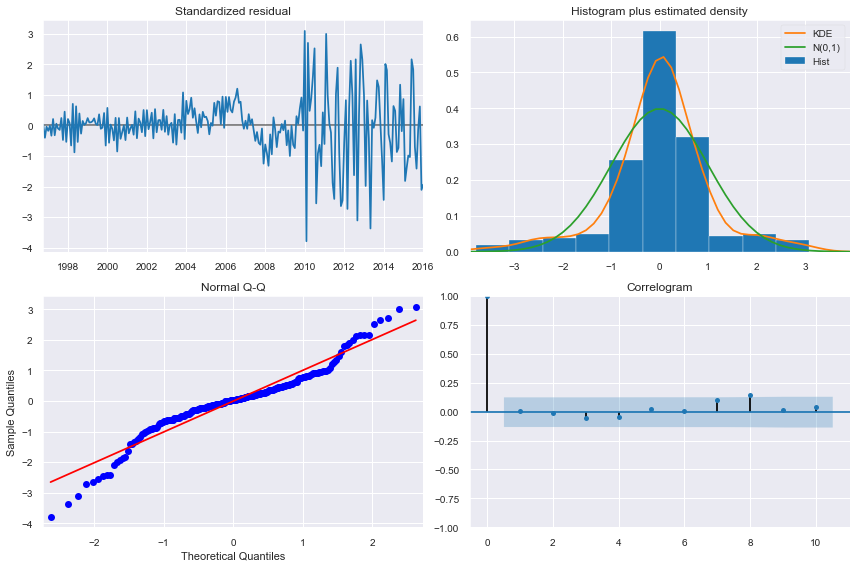

In [31]:
#getting model summary
model_output = SARIMAX(ts_train,**best_params,
                      enforce_invertibility=False,
                      enforce_stationarity=False).fit()
display(model_output.summary())
model_output.plot_diagnostics(figsize=(12,8));
plt.tight_layout()

In [32]:
#viewing training data
ts_train

Month
1996-04-01    101900.0
1996-05-01    101700.0
1996-06-01    101600.0
1996-07-01    101400.0
1996-08-01    101300.0
                ...   
2015-09-01    166100.0
2015-10-01    165400.0
2015-11-01    165500.0
2015-12-01    164900.0
2016-01-01    162600.0
Freq: MS, Name: 79902, Length: 238, dtype: float64

def ROI and model evaluation functions

In [33]:
# docstring for func( one sentence summary)

In [34]:
#Evaluating the model

def model_evaluation(ts_true,ts_pred,show=True):
    """pass in ts_true, ts_pred and return res"""
    from sklearn.metrics import mean_squared_error,r2_score

    res= [['Metric','Value']]
    
    res.append(['RMSE', np.sqrt(mean_squared_error(ts_true,ts_pred))])
    
    res.append(['R2',r2_score(ts_true,ts_pred)])
    
    res = pd.DataFrame(res[1:], columns= res[0])
    
    if show:
        display(res)
    return res
    
def expected_roi(investment, final_value):
    """pass in investment and final value"""
    """This function takes in a series of forecasts to predict the return
    on investment spanning the entire forecast."""
    roi = np.round(((final_value - investment) / investment)*100,3)
    return roi

In [35]:
ts_train.name

79902

In [36]:
def model_predictions(model_output,ts_train,ts_test,start=None,end=None):
    """ This function takes in model_output, training data and test data to return predictions"""
    if start is None:
        start=ts_test.index[0]
        
    if end is None:
        end=ts_test.index[-1] 
        
    prediction = model_output.get_prediction(start=start,end=end, 
                                             dynamic=True)
    
    
    preds_df = prediction.conf_int()
    preds_df['predicted_mean'] = prediction.predicted_mean
    plot_df = pd.concat([preds_df,ts_train],axis=1)
    
    return preds_df
      

In [37]:
def plot_pred(ts_train, ts_test, preds_df, start=None, end=None, just_predictions=False ):
    """This function takes in training data, test data and predicted data"""
    
    if start is None:
        start = ts_test.index[0]
    if end is None:
        end =  ts_test.index[-1]
    
    prediction = model_output.get_prediction( start=start,end=end, 
                                             dynamic=True)
    
    zc =ts_train.name 
    
    fig, ax = plt.subplots()
    ts_train.plot(ax=ax,label='Training Data')
    if just_predictions == False:
        
        ts_test.plot(ax=ax,label='Test Data')

     
    
    preds_df['predicted_mean'].plot(ax=ax)
    ax.fill_between(preds_df.index, preds_df[f'lower {zc}'],
                preds_df[f'upper {zc}'], color="k", alpha=.15,
                label = 'confidence interval')
    if just_predictions == False:
        prediction.predicted_mean.plot(ax=ax,label='Predicted')

    
    roi = expected_roi(preds_df['predicted_mean'].iloc[0],preds_df['predicted_mean'].iloc[-1])
    
    ax.legend()
    ax.set(title=f"Predictions for {zc}: ROI = {roi}%")
    
    fig = ax.get_figure()
    
    
    preds_df['zipcode']= ts_train.name
    plt.show()
    
    return fig


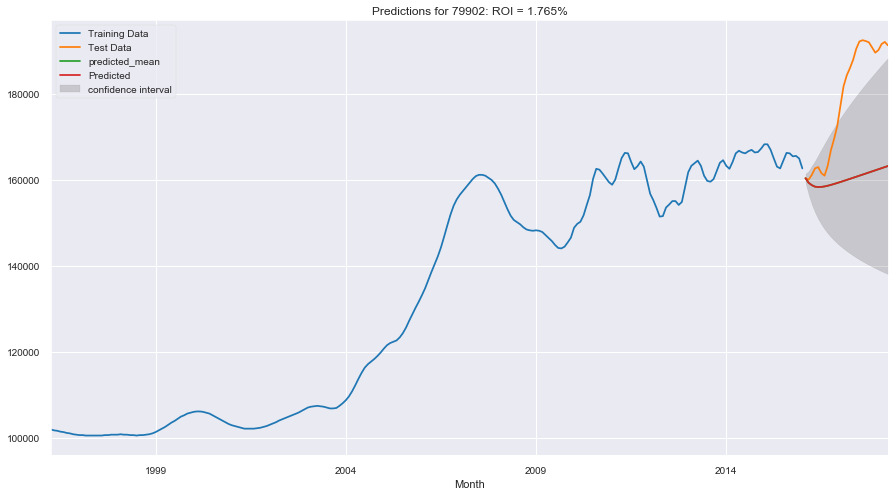

,Metric,Value
0,RMSE,21720.777844
1,R2,-1.798481


In [38]:
preds_df = model_predictions(model_output, ts_train, ts_test)
plot_pred(ts_train, ts_test, preds_df)
res = model_evaluation(ts_test, preds_df['predicted_mean'])

In [39]:
tsdict

{79936: Month
 1996-04-01     77300.0
 1996-05-01     77300.0
 1996-06-01     77300.0
 1996-07-01     77300.0
 1996-08-01     77400.0
                 ...   
 2017-12-01    120300.0
 2018-01-01    120300.0
 2018-02-01    120500.0
 2018-03-01    121000.0
 2018-04-01    121500.0
 Freq: MS, Name: 79936, Length: 265, dtype: float64, 79912: Month
 1996-04-01    119700.0
 1996-05-01    119700.0
 1996-06-01    119800.0
 1996-07-01    119900.0
 1996-08-01    120000.0
                 ...   
 2017-12-01    184700.0
 2018-01-01    184800.0
 2018-02-01    185900.0
 2018-03-01    187200.0
 2018-04-01    188100.0
 Freq: MS, Name: 79912, Length: 265, dtype: float64, 79938: Month
 1996-04-01     98400.0
 1996-05-01     97700.0
 1996-06-01     97200.0
 1996-07-01     96700.0
 1996-08-01     96300.0
                 ...   
 2017-12-01    143800.0
 2018-01-01    143700.0
 2018-02-01    143900.0
 2018-03-01    144400.0
 2018-04-01    144600.0
 Freq: MS, Name: 79938, Length: 265, dtype: float64, 79924: Mo

# Meta grid search

In [40]:
#fig,ax,tsdict = plot_ts_dict(El_P)

In [41]:
print(ts.index[0])
ts.index[0]+ pd.to_timedelta(1,'MS')
end=ts.index[0]+ pd.to_timedelta(1,'MS')
pd.to_datetime(end)

1996-04-01 00:00:00


Timestamp('1996-04-01 00:00:00.001000', freq='MS')



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79936
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:07:09 PM:


100%|██████████| 36/36 [00:19<00:00,  1.83it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:07:28 PM
	Total Time: 0:00:19.707282
Best params:  {'order': (3, 2, 3)}


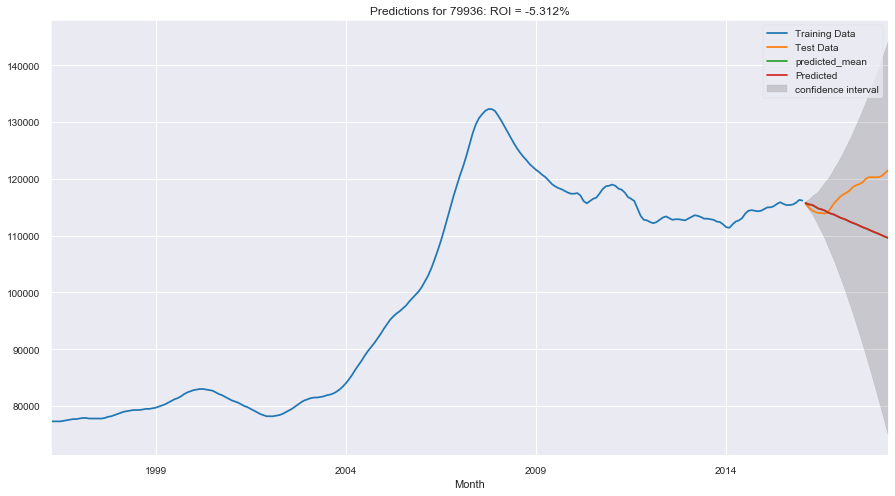



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79912
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:07:31 PM:


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:07:51 PM
	Total Time: 0:00:20.243722
Best params:  {'order': (1, 2, 3)}


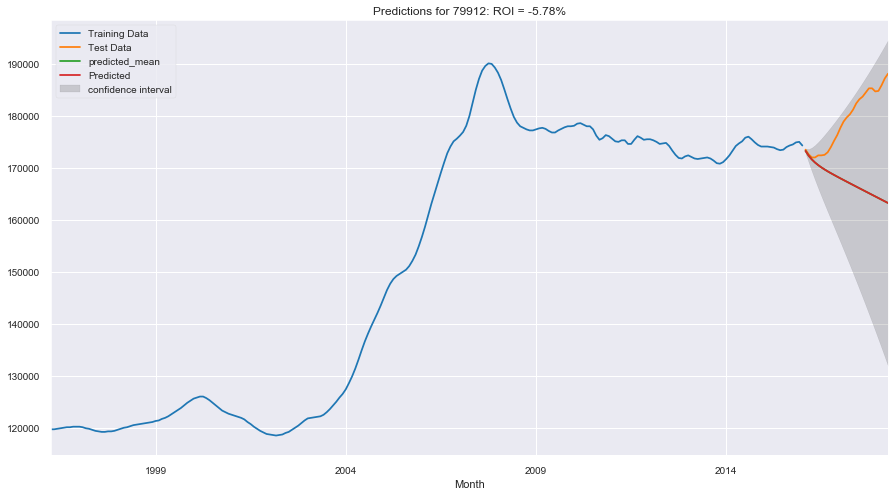



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79938
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:07:54 PM:


100%|██████████| 36/36 [00:17<00:00,  2.06it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:08:11 PM
	Total Time: 0:00:17.516852
Best params:  {'order': (3, 2, 3)}


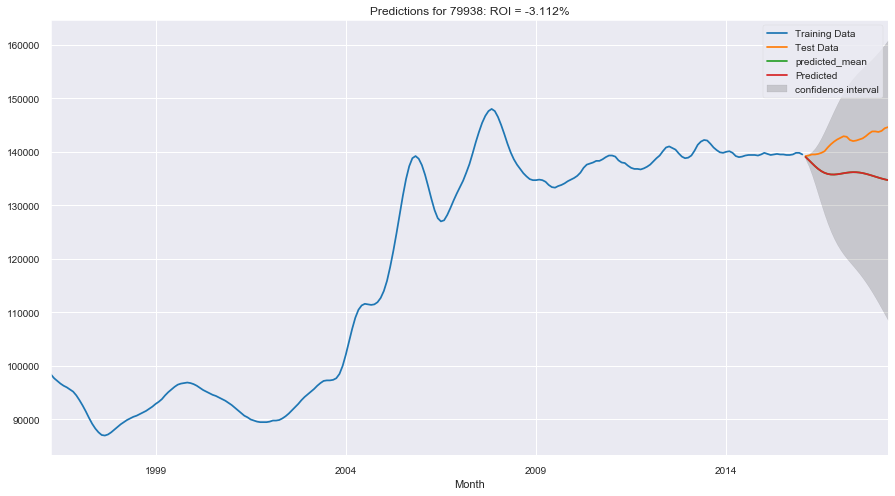



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79924
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:08:15 PM:


100%|██████████| 36/36 [00:19<00:00,  1.89it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:08:34 PM
	Total Time: 0:00:19.081745
Best params:  {'order': (3, 3, 3)}


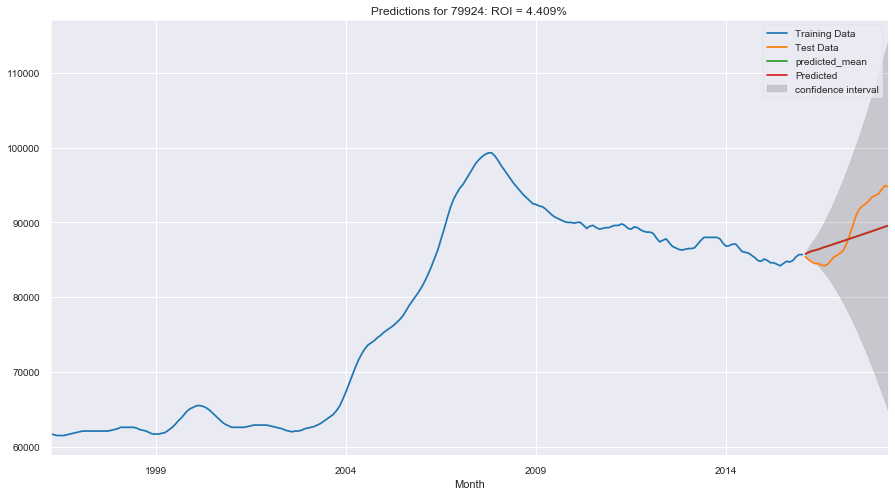



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79907
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:08:38 PM:


100%|██████████| 36/36 [00:21<00:00,  1.71it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:08:59 PM
	Total Time: 0:00:21.028721
Best params:  {'order': (1, 2, 3)}


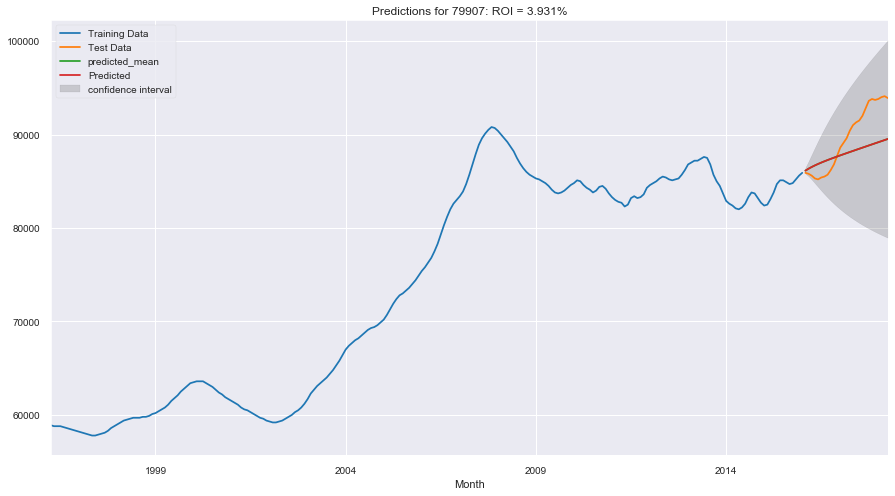



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79925
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:09:02 PM:


100%|██████████| 36/36 [00:21<00:00,  1.64it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:09:24 PM
	Total Time: 0:00:22.015708
Best params:  {'order': (3, 2, 3)}


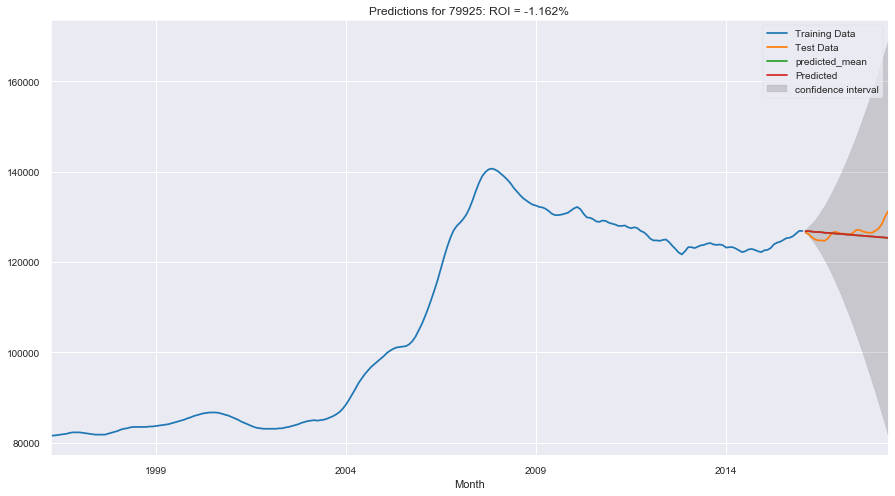



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79915
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:09:27 PM:


100%|██████████| 36/36 [00:20<00:00,  1.75it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:09:48 PM
	Total Time: 0:00:20.644981
Best params:  {'order': (3, 1, 3)}


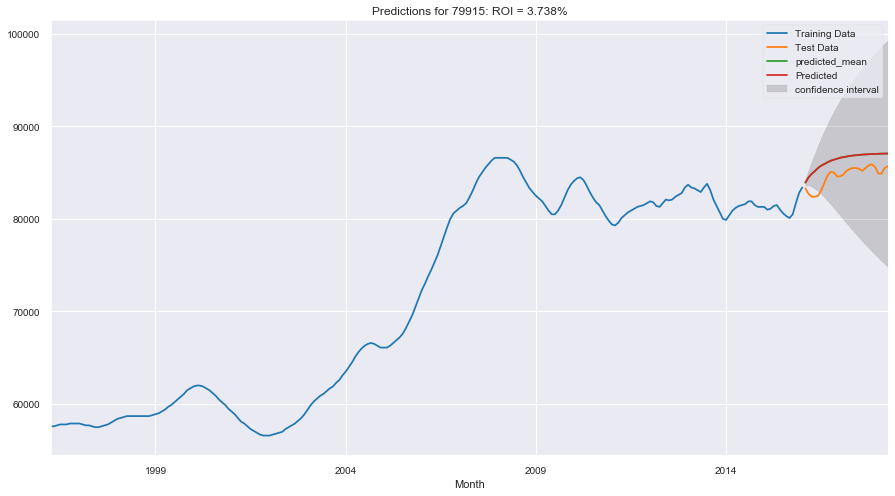



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79904
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:09:50 PM:


100%|██████████| 36/36 [00:23<00:00,  1.55it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:10:13 PM
	Total Time: 0:00:23.207244
Best params:  {'order': (3, 1, 3)}


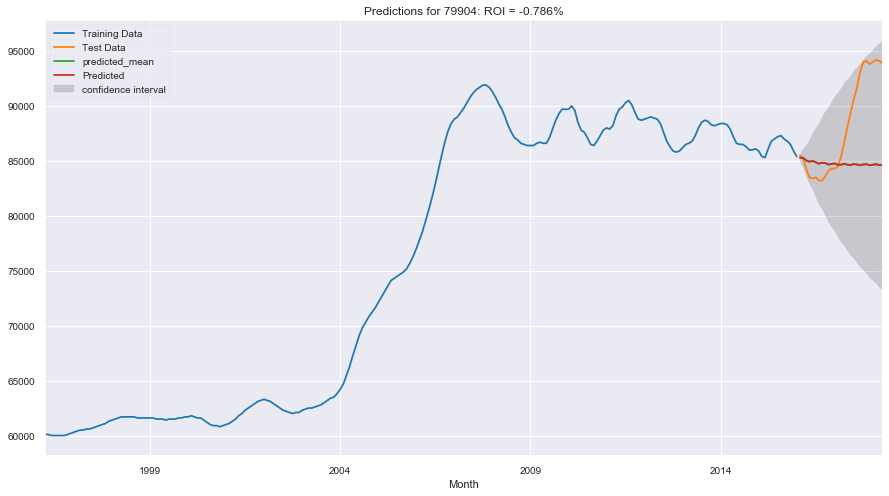



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79902
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:10:17 PM:


100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:10:35 PM
	Total Time: 0:00:18.850750
Best params:  {'order': (3, 2, 3)}


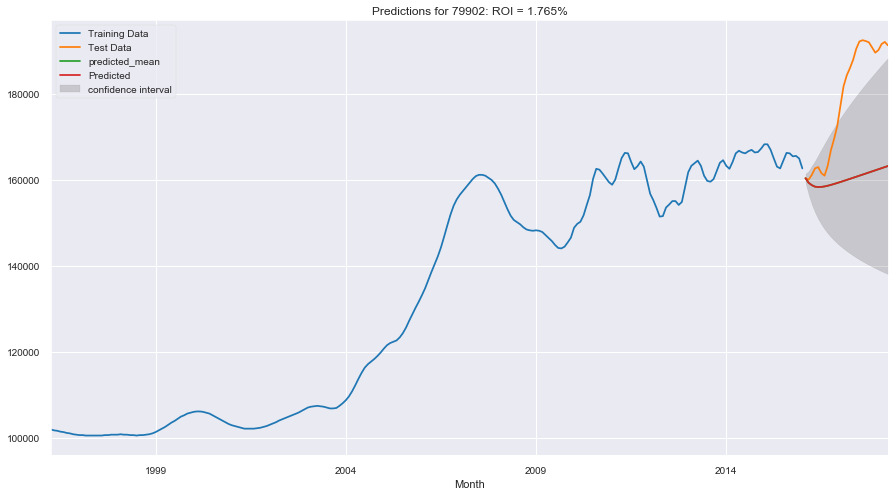



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79934
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:10:39 PM:


100%|██████████| 36/36 [00:13<00:00,  2.69it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:10:52 PM
	Total Time: 0:00:13.400824
Best params:  {'order': (1, 3, 3)}


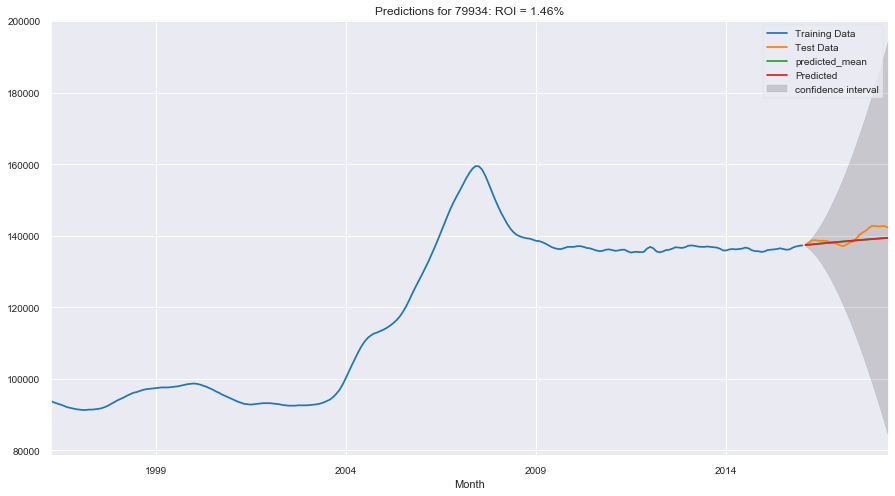



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79930
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:10:55 PM:


100%|██████████| 36/36 [00:19<00:00,  1.85it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:11:15 PM
	Total Time: 0:00:19.429741
Best params:  {'order': (1, 2, 3)}


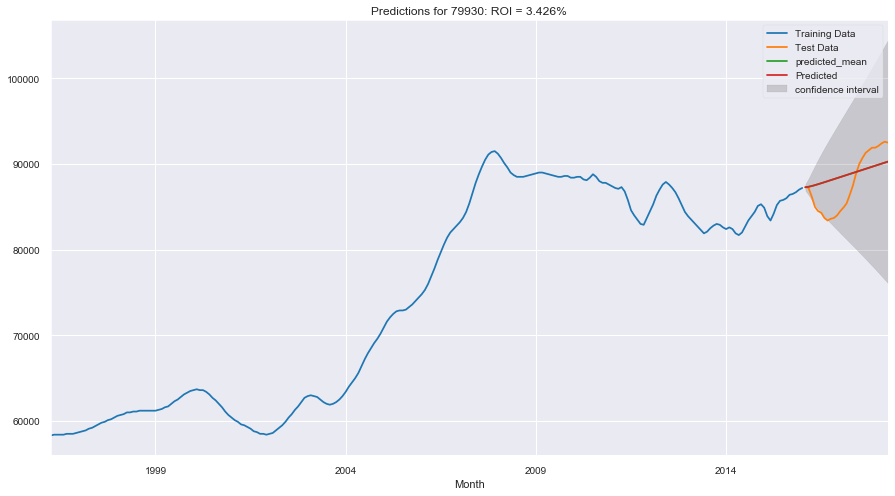



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79932
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:11:17 PM:


100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:11:36 PM
	Total Time: 0:00:19.138724
Best params:  {'order': (3, 3, 3)}


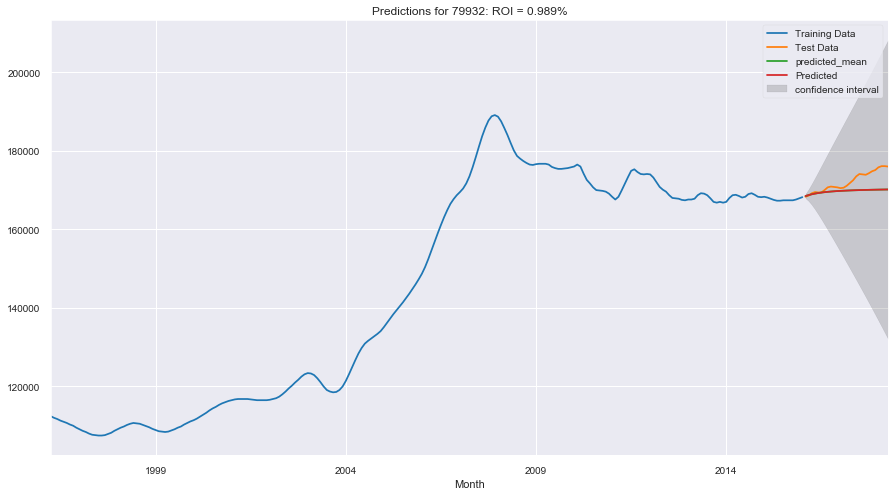



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79905
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:11:40 PM:


100%|██████████| 36/36 [00:19<00:00,  1.81it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:12:00 PM
	Total Time: 0:00:19.936736
Best params:  {'order': (3, 1, 3)}


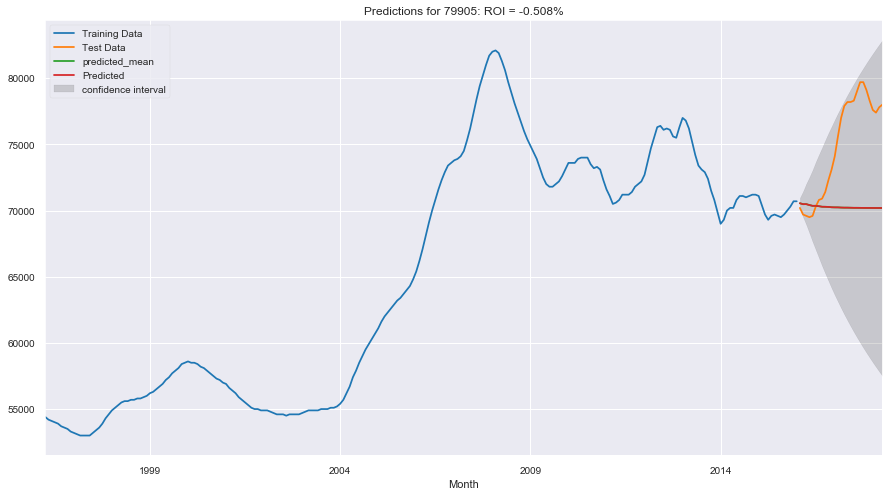



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79903
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:12:02 PM:


100%|██████████| 36/36 [00:18<00:00,  1.94it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:12:21 PM
	Total Time: 0:00:18.582754
Best params:  {'order': (3, 1, 3)}


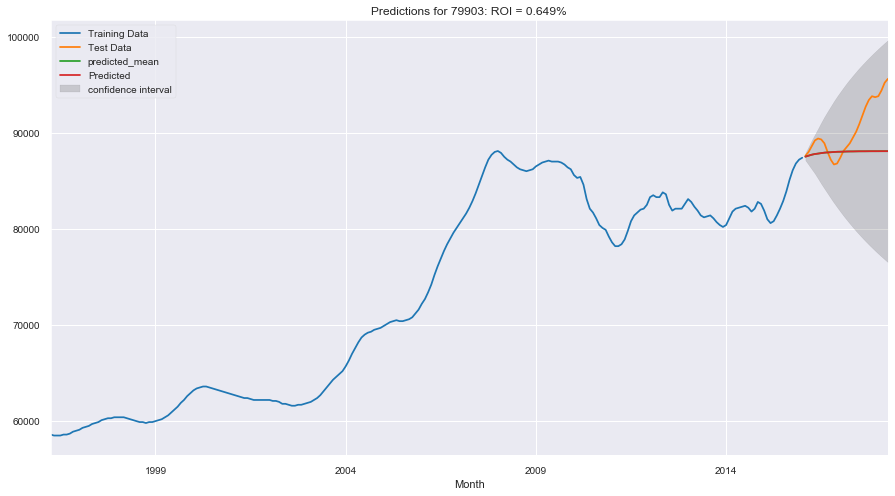



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79935
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:12:23 PM:


100%|██████████| 36/36 [00:15<00:00,  2.30it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:12:39 PM
	Total Time: 0:00:15.685789
Best params:  {'order': (3, 3, 3)}


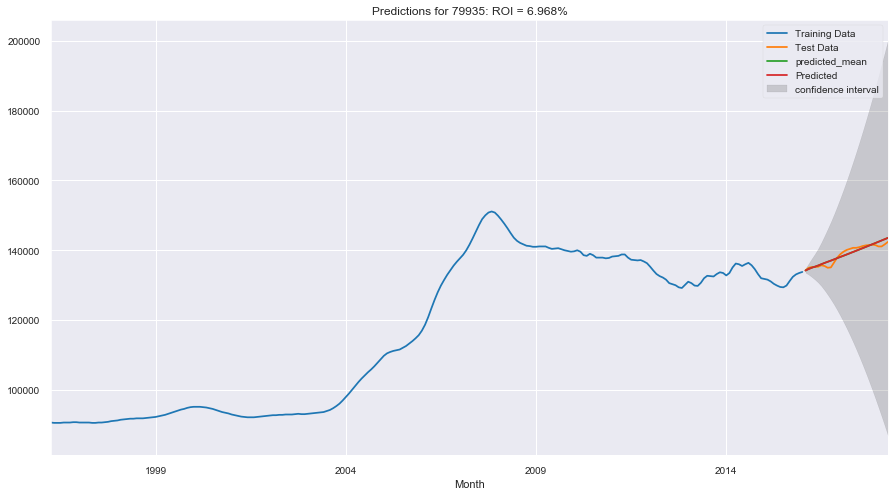



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79901
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:12:42 PM:


100%|██████████| 36/36 [00:20<00:00,  1.75it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:13:03 PM
	Total Time: 0:00:20.629723
Best params:  {'order': (3, 3, 3)}


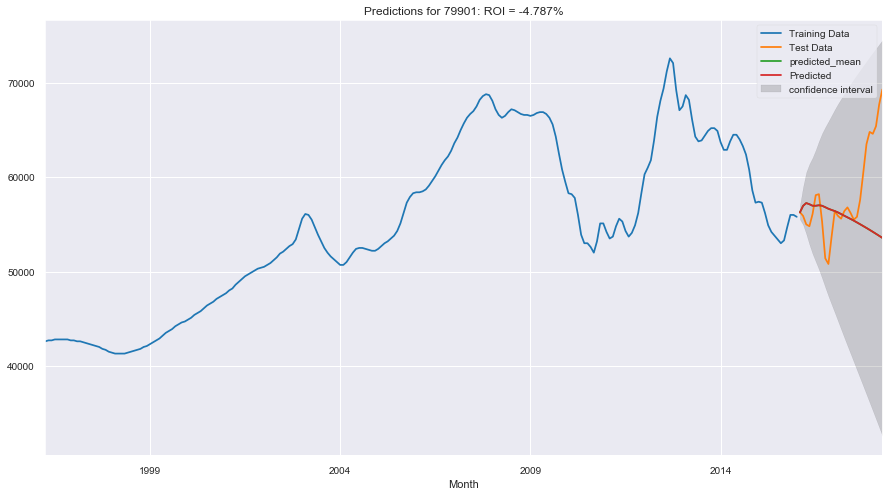



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79922
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:13:09 PM:


100%|██████████| 36/36 [00:16<00:00,  2.19it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:13:25 PM
	Total Time: 0:00:16.463760
Best params:  {'order': (3, 2, 3)}


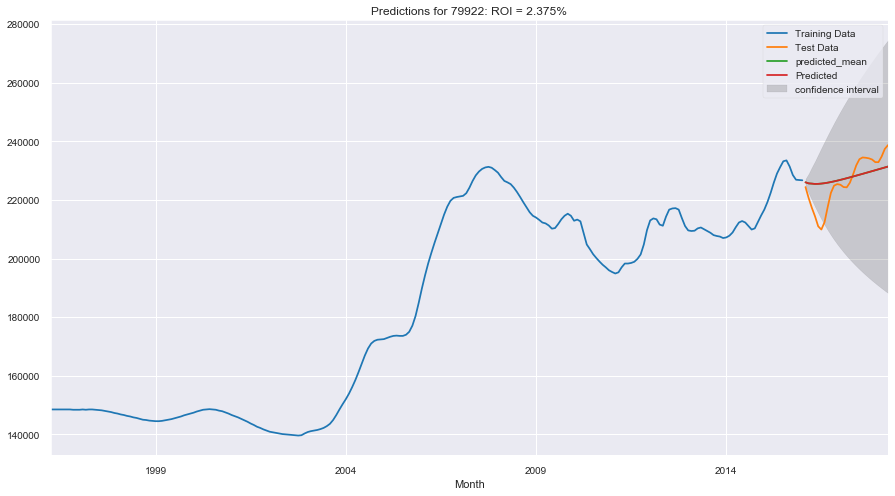



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79911
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:13:28 PM:


100%|██████████| 36/36 [00:21<00:00,  1.71it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:13:49 PM
	Total Time: 0:00:21.068715
Best params:  {'order': (3, 2, 3)}


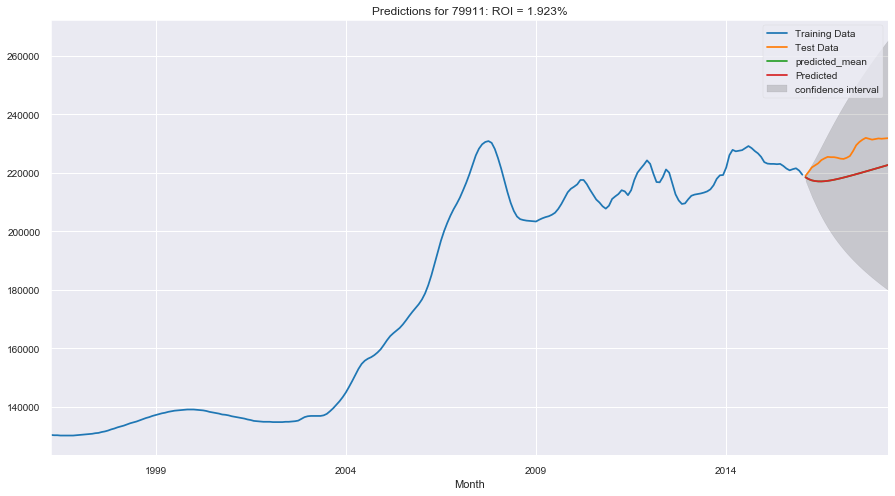



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79836
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:13:52 PM:


100%|██████████| 36/36 [00:08<00:00,  4.16it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:14:00 PM
	Total Time: 0:00:08.674888
Best params:  {'order': (3, 3, 3)}


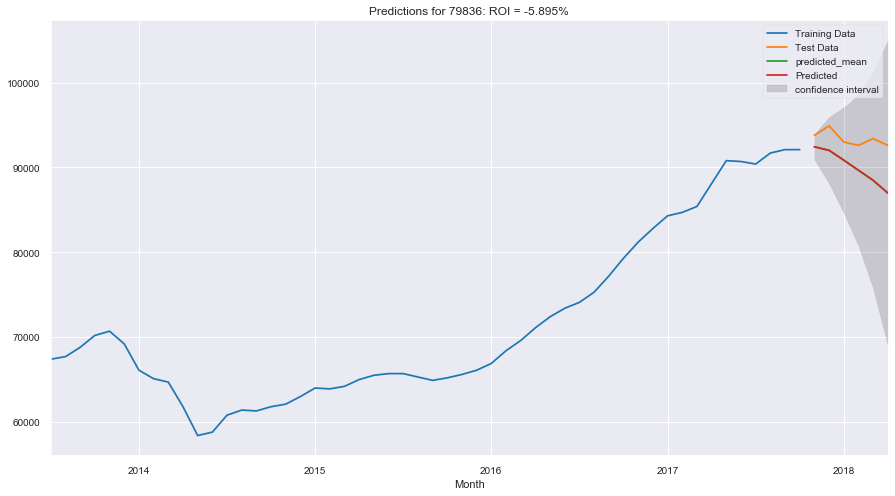

In [42]:
params = make_pdq_pdqm()

ts_resdict = {}
for zc,ts in tsdict.items():
    print('\n')
    print('---'*30)
    print('---'*30)
    print(f'ZIPCODE: {zc}')
    ## Train test split
    ts_train,ts_test = train_test_split_ts(ts,test_size=0.1)
    

    ## Grid search
    res = grid_search(ts_train,order_dict=params,make_seasonal=False)#pdq,pdqm)
    #res = pd.DataFrame(res[1:], columns= res[0])
    res.sort_values('AIC',inplace=True)
    best_params =  dict(order=res.iloc[0].loc['pdq'])
    
    ts_resdict[zc]={}
    ts_resdict[zc]['res']=res
    ts_resdict[zc]['best_params'] = best_params
    print('Best params: ',best_params)
    

    ## Using best params
    model_output = SARIMAX(ts_train,**best_params,
                      enforce_invertibility=False,
                      enforce_stationarity=False).fit()
    ts_resdict[zc]['model'] = model_output
    
    preds_df = model_predictions(model_output, ts_train, ts_test)
    plot_pred(ts_train, ts_test, preds_df)
    ts_resdict[zc]['preds_df'] = preds_df

In [43]:
res

,pdq,PDQM,AIC
35,"(3, 3, 3)",N/A,737.800952
32,"(3, 2, 3)",N/A,741.928303
20,"(1, 2, 3)",N/A,748.789003
8,"(0, 2, 3)",N/A,751.226943
23,"(1, 3, 3)",N/A,759.164270
11,"(0, 3, 3)",N/A,759.322990
5,"(0, 1, 3)",N/A,762.754259
31,"(3, 2, 1)",N/A,763.214920
17,"(1, 1, 3)",N/A,764.465832
34,"(3, 3, 1)",N/A,764.882540


# Step 6: Interpreting Results



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79936
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:14:03 PM:


100%|██████████| 36/36 [00:18<00:00,  1.98it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:14:21 PM
	Total Time: 0:00:18.220755
Best params:  {'order': (3, 2, 3)}


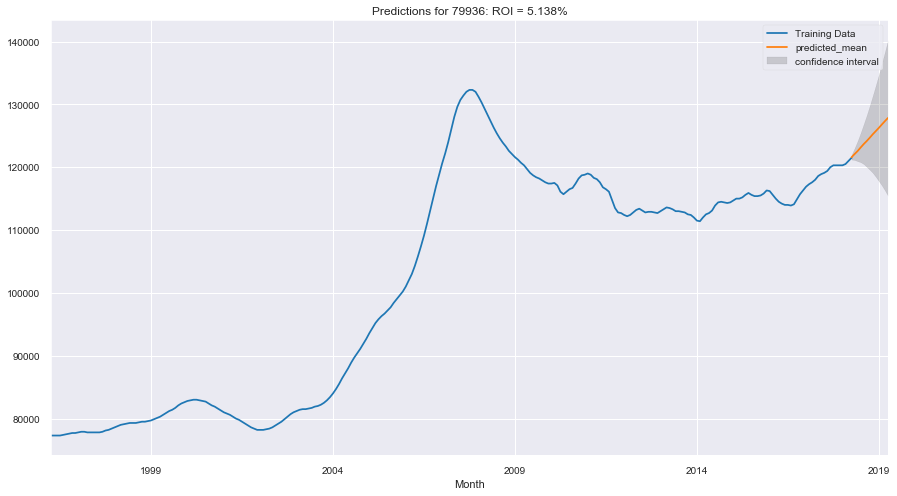



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79912
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:14:24 PM:


100%|██████████| 36/36 [00:21<00:00,  1.65it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:14:46 PM
	Total Time: 0:00:21.816079
Best params:  {'order': (1, 2, 3)}


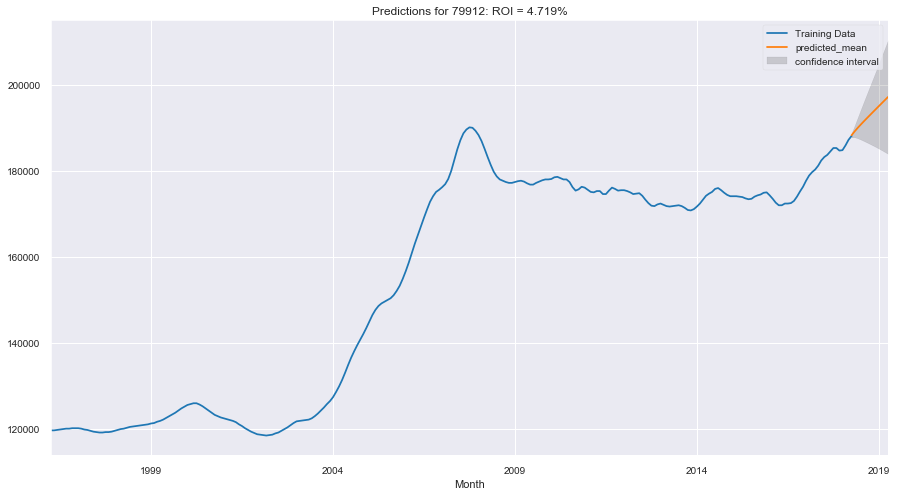



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79938
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:14:49 PM:


100%|██████████| 36/36 [00:20<00:00,  1.74it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:15:10 PM
	Total Time: 0:00:20.817240
Best params:  {'order': (3, 2, 3)}


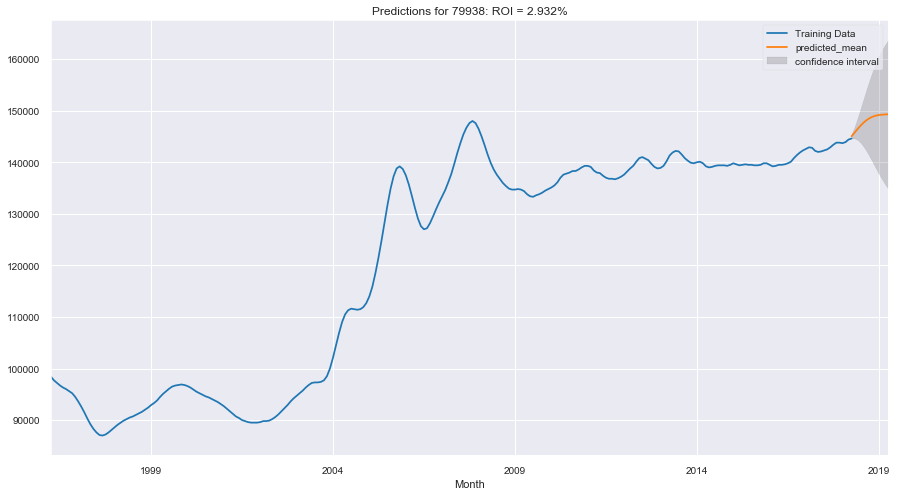



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79924
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:15:16 PM:


100%|██████████| 36/36 [00:33<00:00,  1.07it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:15:50 PM
	Total Time: 0:00:33.532660
Best params:  {'order': (3, 3, 3)}


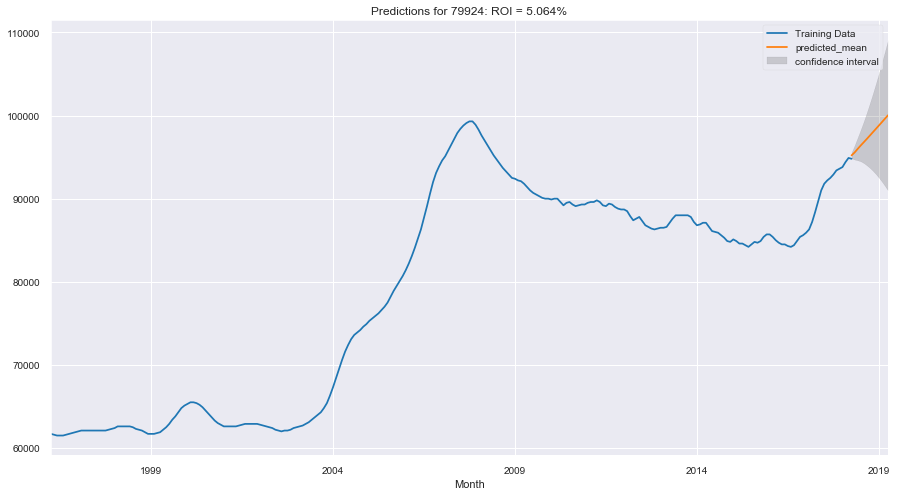



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79907
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:15:55 PM:


100%|██████████| 36/36 [00:24<00:00,  1.45it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:16:20 PM
	Total Time: 0:00:24.881666
Best params:  {'order': (1, 2, 3)}


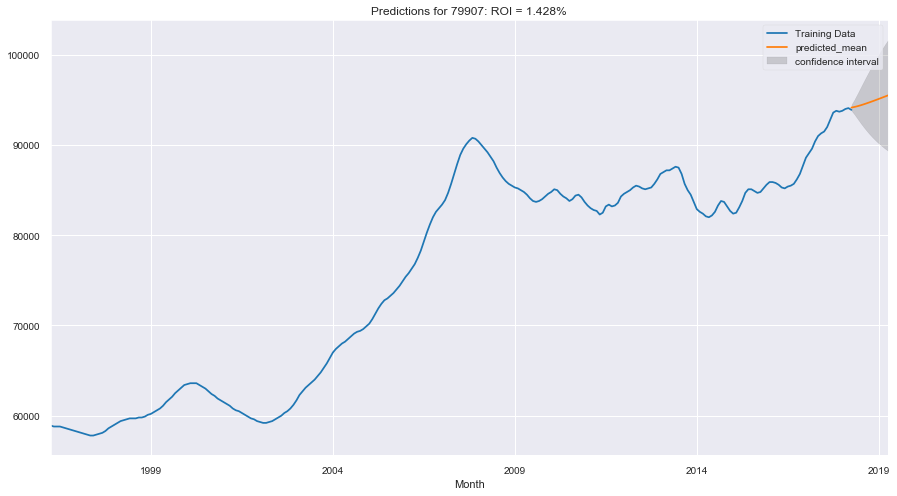



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79925
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:16:23 PM:


100%|██████████| 36/36 [00:24<00:00,  1.46it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:16:48 PM
	Total Time: 0:00:24.635671
Best params:  {'order': (3, 2, 3)}


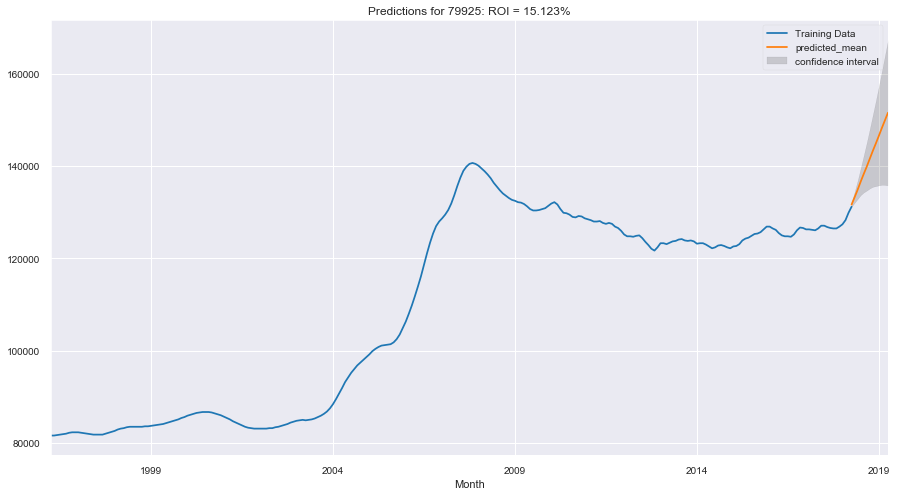



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79915
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:16:51 PM:


100%|██████████| 36/36 [00:23<00:00,  1.53it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:17:15 PM
	Total Time: 0:00:23.555687
Best params:  {'order': (3, 1, 3)}


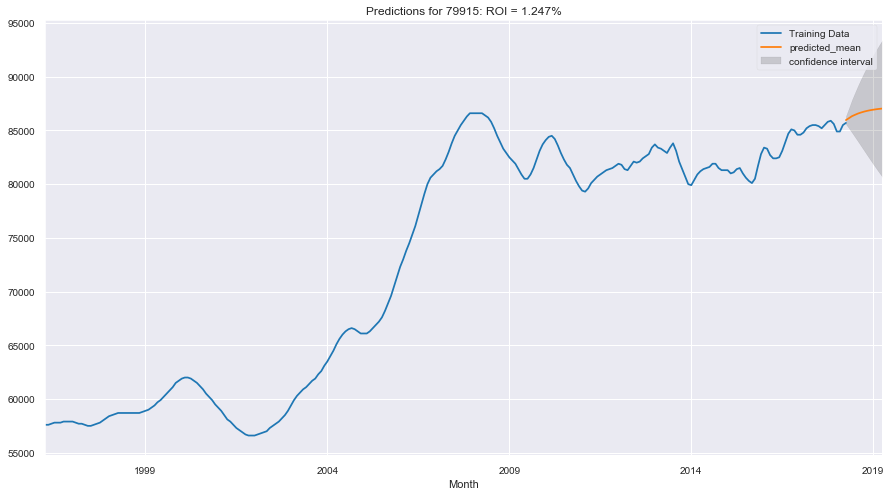



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79904
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:17:18 PM:


100%|██████████| 36/36 [00:23<00:00,  1.54it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:17:41 PM
	Total Time: 0:00:23.459721
Best params:  {'order': (3, 1, 3)}


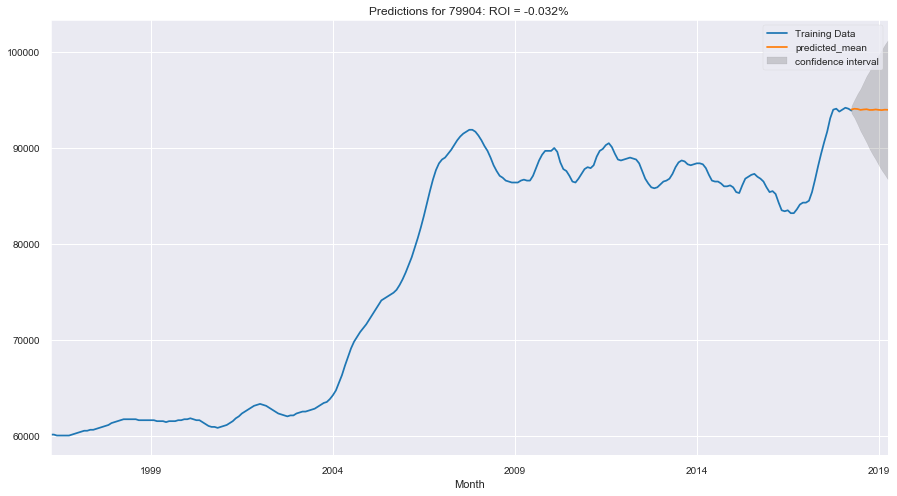



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79902
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:17:45 PM:


100%|██████████| 36/36 [00:22<00:00,  1.63it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:18:07 PM
	Total Time: 0:00:22.035727
Best params:  {'order': (3, 2, 3)}


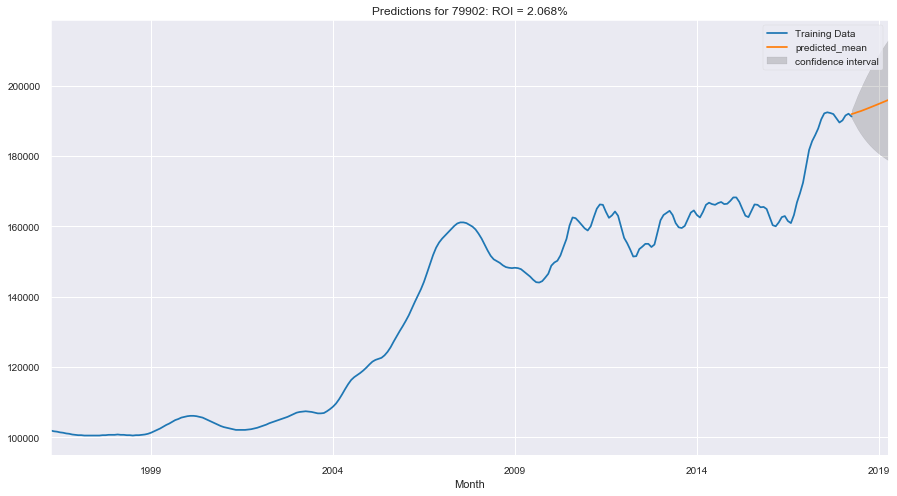



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79934
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:18:11 PM:


100%|██████████| 36/36 [00:15<00:00,  2.28it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:18:27 PM
	Total Time: 0:00:15.834811
Best params:  {'order': (1, 3, 3)}


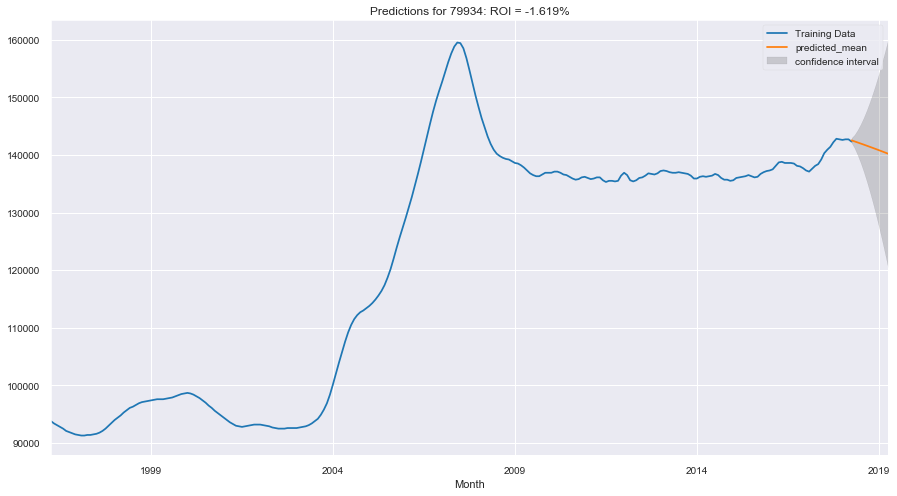



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79930
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:18:31 PM:


100%|██████████| 36/36 [00:20<00:00,  1.75it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:18:51 PM
	Total Time: 0:00:20.558728
Best params:  {'order': (1, 2, 3)}


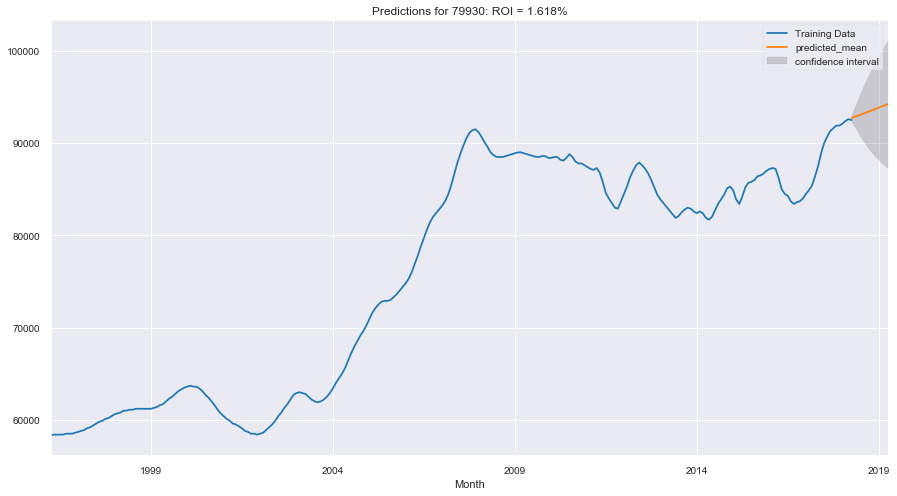



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79932
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:18:54 PM:


100%|██████████| 36/36 [00:21<00:00,  1.70it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:19:15 PM
	Total Time: 0:00:21.232243
Best params:  {'order': (3, 3, 3)}


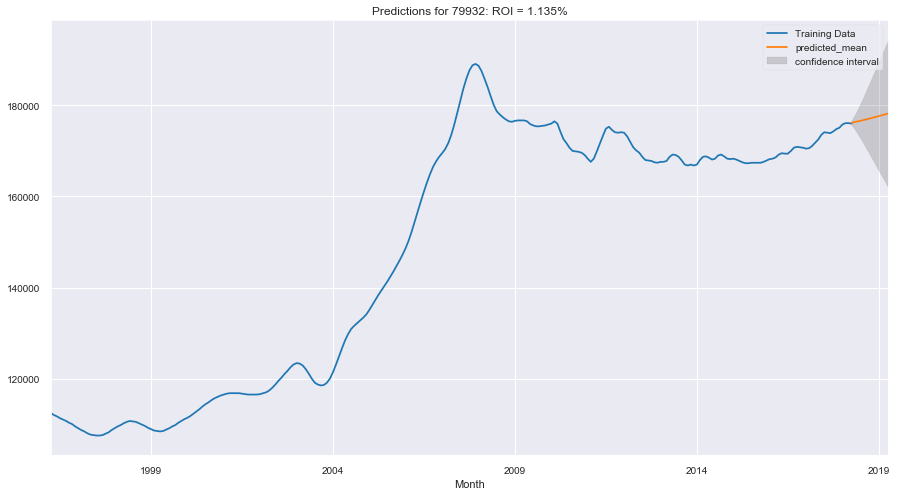



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79905
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:19:20 PM:


100%|██████████| 36/36 [00:20<00:00,  1.76it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:19:40 PM
	Total Time: 0:00:20.535728
Best params:  {'order': (3, 1, 3)}


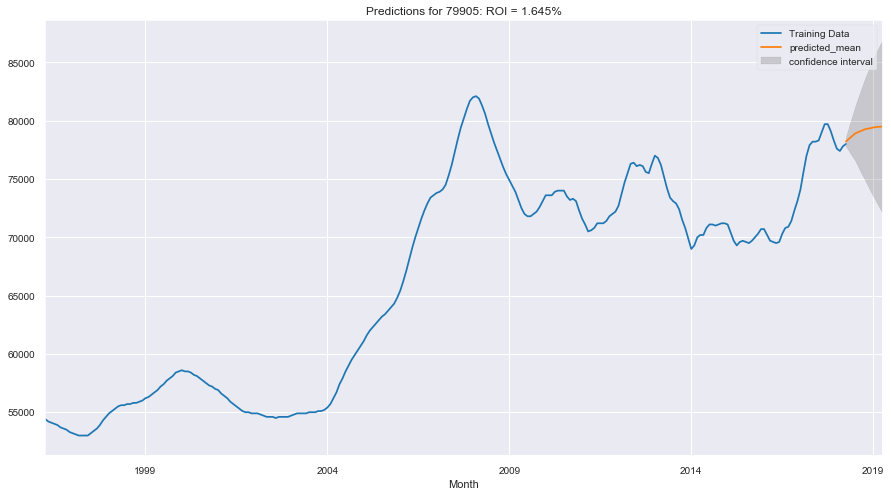



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79903
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:19:43 PM:


100%|██████████| 36/36 [00:18<00:00,  1.98it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:20:01 PM
	Total Time: 0:00:18.178740
Best params:  {'order': (3, 1, 3)}


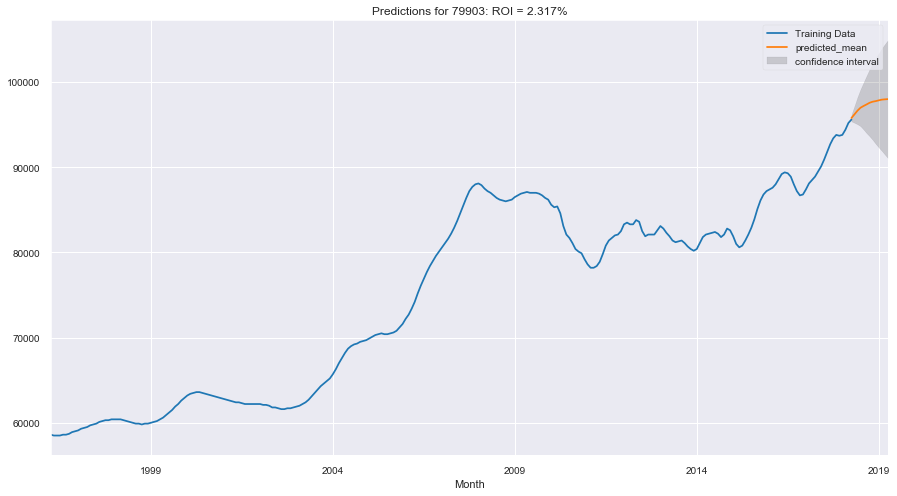



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79935
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:20:03 PM:


100%|██████████| 36/36 [00:14<00:00,  2.41it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:20:18 PM
	Total Time: 0:00:14.971801
Best params:  {'order': (3, 3, 3)}


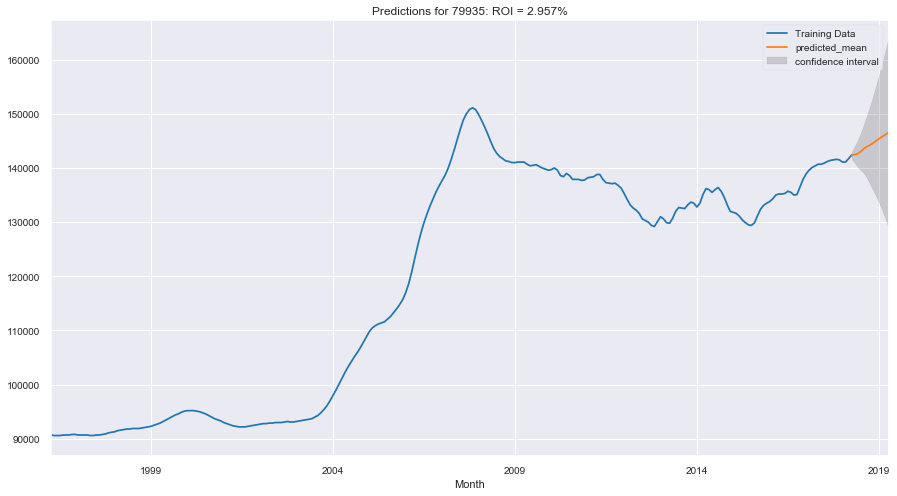



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79901
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:20:22 PM:


100%|██████████| 36/36 [00:20<00:00,  1.75it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:20:43 PM
	Total Time: 0:00:20.578726
Best params:  {'order': (3, 3, 3)}


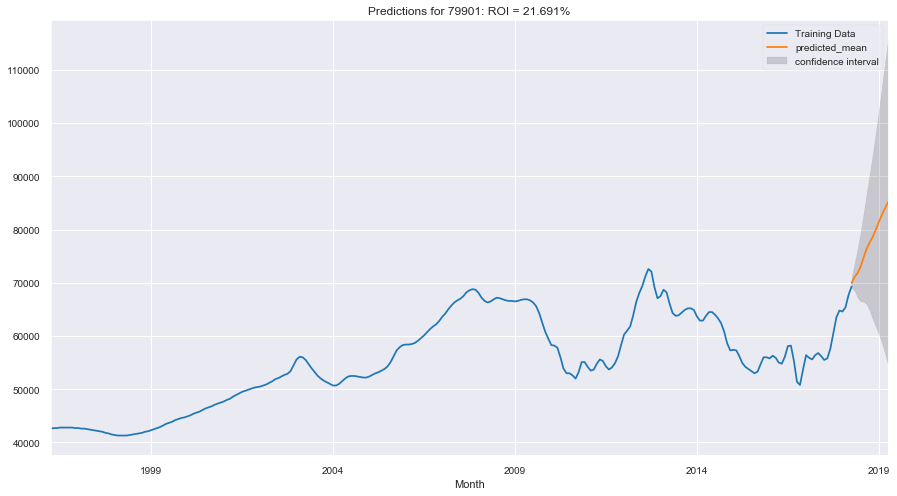



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79922
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:20:45 PM:


100%|██████████| 36/36 [00:15<00:00,  2.27it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:21:01 PM
	Total Time: 0:00:15.905786
Best params:  {'order': (3, 2, 3)}


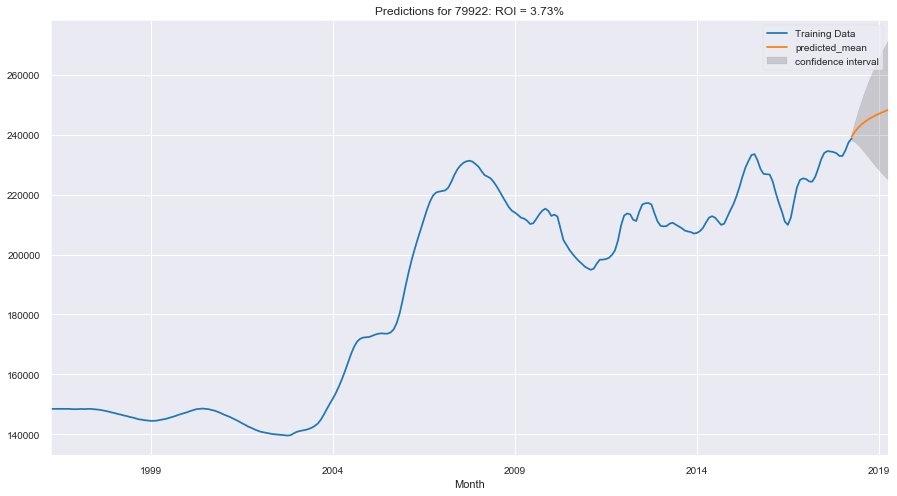



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79911
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:21:05 PM:


100%|██████████| 36/36 [00:20<00:00,  1.73it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:21:25 PM
	Total Time: 0:00:20.797378
Best params:  {'order': (3, 2, 3)}


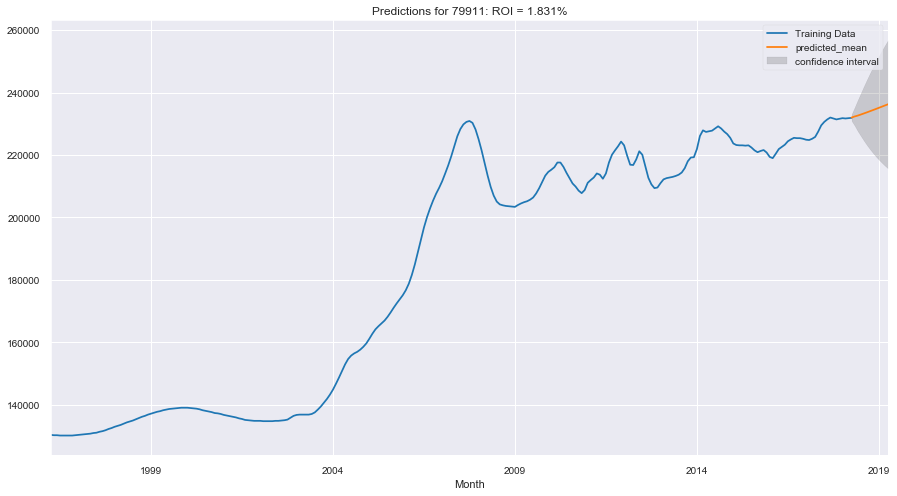



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79836
[i] STARTING GRID SEARCH @ 01/27/2020 - 03:21:29 PM:


100%|██████████| 36/36 [00:07<00:00,  5.01it/s]


[i] GRID SEARCH FINISHED AT 01/27/2020 - 03:21:36 PM
	Total Time: 0:00:07.198904
Best params:  {'order': (3, 3, 3)}


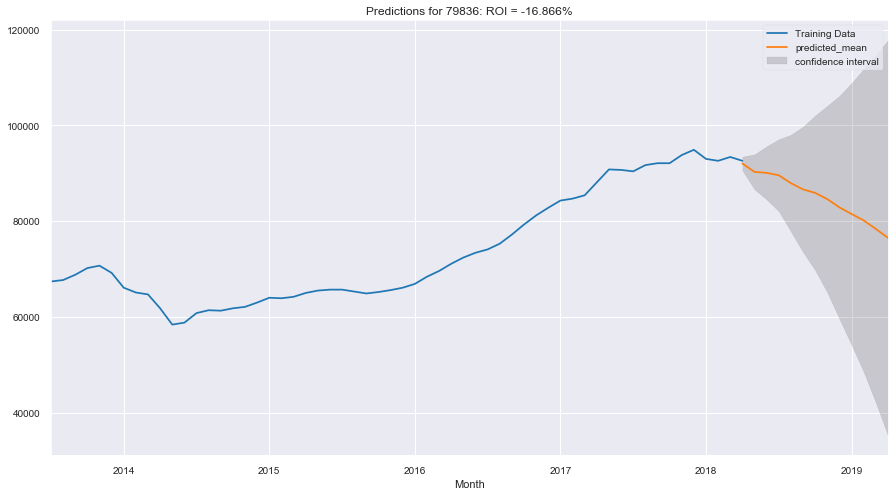

In [44]:
params = make_pdq_pdqm()

ts_resdict = {}
for zc,ts in tsdict.items():
    print('\n')
    print('---'*30)
    print('---'*30)
    print(f'ZIPCODE: {zc}')
    ## Train test split
    ts_train,ts_test = train_test_split_ts(ts,test_size=0.1)
    

    ## Grid search
    res = grid_search (ts_train,order_dict=params,make_seasonal=False)#|pdq,pdqm)
    #res = pd.DataFrame(res[1:], columns= res[0])
    res.sort_values('AIC',inplace=True)
    best_params =  dict(order=res.iloc[0].loc['pdq'])
    
    ts_resdict[zc]={}
    ts_resdict[zc]['res']=res
    ts_resdict[zc]['best_params'] = best_params
    print('Best params: ',best_params)
    

    ## Using best params
    model_output = SARIMAX(ts,**best_params,
                      enforce_invertibility=False,
                      enforce_stationarity=False).fit()
    ts_resdict[zc]['model'] = model_output
    
    preds_df = model_predictions(model_output,ts_train,ts_test,
                                         start=ts.index[-1],end=ts.index.shift(12)[-1])#+ pd.to_timedelta(1,'MS'))
    plot_pred(ts, ts_test, preds_df, just_predictions=True)
    ts_resdict[zc]['preds_df'] = preds_df
    

# CONCLUSION

From our model, we  came up with these 5 top zip codes with the highest ROI
based on the risk level from 1 to 5.
The risk is based on the confidence interval indicating the potential for loss of money
<img src="images/summary table.png" width=70%>

# Best 5 zip codes to invest in the city of El paso

In [45]:
print('79901 = 21.691%')
print('79925 = 15.123%')
print('79936 = 5.138%')
print('79924 = 5.064%')
print('79912 = 4.719%')

79901 = 21.691%
79925 = 15.123%
79936 = 5.138%
79924 = 5.064%
79912 = 4.719%
